In [32]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats import descriptivestats

In [33]:
results = Result.objects.filter(n_tiles=20, improved_sel=True)

In [34]:
results.values('score')

<QuerySet [{'score': 0.0}, {'score': 1.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 1.0}, {'score': 0.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 2.0}, {'score': 1.0}, {'score': 0.0}, {'score': 2.0}, {'score': 0.0}, {'score': 1.0}, {'score': 1.0}, {'score': 2.0}, '...(remaining elements truncated)...']>

In [35]:
def calc_p_value(results, max_depth_instances, avg_depth_instances, is_guillotine=True): 
    max_depth_wins = 0
    avg_depth_wins = 0
    draws = 0
    values = []
    for max_depth_res in max_depth_instances:
        if is_guillotine:
            kwargs = {'problem_id': max_depth_res.problem_id}
        else:
            kwargs = {'their_id': max_depth_res.their_id}
        kwargs['score__isnull'] =  False
        avg_depth_res = results.filter(
            strategy='avg_depth',
            **kwargs,
            )
        if avg_depth_res.count() == 1:
            avg_depth_score = avg_depth_res.first().score
            max_depth_score = max_depth_res.score
            if avg_depth_score > max_depth_score: # lower is better
                max_depth_wins +=1 
                values.append(1)
            elif avg_depth_score < max_depth_score:
                avg_depth_wins += 1
                values.append(-1)
            else:
                draws += 1
                
    print(f'In total max_depth_wins: {max_depth_wins}, avg_depth_wins: {avg_depth_wins}, and {draws} ties.')
    
    m = descriptivestats.sign_test(values)
    print(f'p value: {m[1]}')

In [36]:
'''
gets problem_id's of problems which were solved by all variations
'''
def get_best_problem_ids(N=1000, guillotine=True):
    ret = []
    common_args = {'improved_sel': True, 'score__isnull': False}
    problem_ids = set()
    for r in Result.objects.filter(n_simulations=5000, **common_args).order_by('id'):
        if guillotine:
            common_args['problem_generator'] = 'guillotine'
            count = len(set(Result.objects.filter(problem_id=r.problem_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.problem_id, count))
        else:
            common_args['problem_generator'] = 'florian'
            count = len(set(Result.objects.filter(their_id=r.their_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.their_id, count))
            
    problem_ids = sorted(problem_ids, key=lambda x: x[1])
    N_COMBINATIONS = 12 # 100, 200, 500, 1k, 2k, 5k for avg and max depth
    print(len(problem_ids))
    ret = []
    bigger_than_12 = 0
    for x in problem_ids:
        if x[1] == N_COMBINATIONS:
            ret.append(x[0])
        else:
            if x[1] > N_COMBINATIONS:
                bigger_than_12 += 1
    print(bigger_than_12)
    return ret#[:1000]

In [37]:
# best_problem_ids = get_best_problem_ids()
# best_their_ids = get_best_problem_ids(guillotine=False)

import pickle
with open(r"best_problem_ids.pickle", 'rb') as f:
    best_problem_ids = pickle.load(f) 
with open(r"best_their_ids.pickle", 'rb') as f:
    best_their_ids = pickle.load(f) 

In [38]:
#best_their_ids = get_best_problem_ids(guillotine=False)
print(len(best_their_ids))

1000


In [8]:
import pickle,csv
ids_from_csv = set()
with open('puzzles_n20_with_solutions_2.csv') as csvfile:
    csv_reader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    for row in csv_reader:
        id_from_csv = int(row['id'])
        ids_from_csv.add(id_from_csv)
print(len(ids_from_csv))
overlapping_ids = set(best_their_ids).intersection(ids_from_csv)
print(len(overlapping_ids))
        
# with open('best_problem_ids.pickle', 'wb') as f:
#     pickle.dump(best_problem_ids, f
#     
with open('best_their_ids.pickle', 'wb') as f:
    pickle.dump(list(overlapping_ids)[:1000], f)
# print(best_problem_ids)
# print(best_their_ids)

1615
1000


In [9]:
solved_ids = []
with open('exh_solved_b') as csvfile:
    for l in csvfile:
        if 'job_i' in l:
            continue
        solved_ids.append(int(l))

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                   improved_sel=True, strategy='max_depth', score__isnull=False,
                                 ).values_list('id', flat=True)

print(set(b_problems) - set(solved_ids))
print(len(set(b_problems)), len(set(solved_ids)))


FileNotFoundError: [Errno 2] No such file or directory: 'exh_solved_b'

In [10]:
def eliminate_duplicate_tiles(tiles):
    i = 0
    new_tiles = []
    while i < len(tiles):
        tile = tiles[i]
        tiles_without_current_tile = tiles[i + 1:]
        tile_pair_index = tiles_without_current_tile.index([tile[1], tile[0]]) + i + 1
        tiles = tiles[0: tile_pair_index] + tiles[tile_pair_index + 1:]
        i += 1 
    return tiles

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')
all_lists = list(b_problems.values_list('tiles', flat=True))
_all_list_strs = []
for l in all_lists:
    _all_list_strs.append(str(sorted(l)))
print(len(set(_all_list_strs)))
# print(_all_list_strs)

# check if any list contains duplicates inside
for l in all_lists:
    # print(l)
    #l = eliminate_duplicate_tiles(l)
    _l = [tuple(x) for x in l]
    # print(_l)
    new_set = set()
    for el in _l:
        new_set.add(el)
    if len(new_set) != 40:
        print('duplicate found')
        

1000


In [8]:
turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])

def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


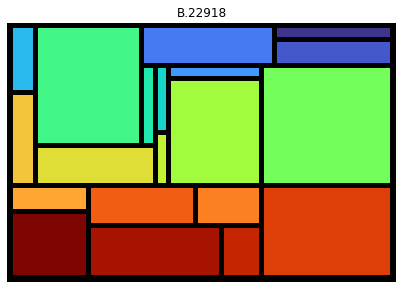

In [57]:
'''
visualize solutions
'''
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

def visualize_grid(grid, rows, cols, lines_tiles=None, next_lfb=None, title=None, step=None, hardness=None):
    import matplotlib
    #matplotlib.use('GTK')
    np.random.seed(4)

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_xticks(list(range(cols)))
    ax1.set_yticks(list(range(rows)))
    ax1.grid(True)
    #print(lines_tiles)
    x1margin = -0.5
    y1margin = -0.5
    if lines_tiles:
        for line in lines_tiles:
            new_line = []
            for point in line:
                point = (point[0] + x1margin, point[1] + y1margin)
                new_line.append(point)
            path = matplotlib.patches.Polygon(new_line, facecolor='none', edgecolor='black',
                                   linewidth=5, closed=True, joinstyle='round')
            ax1.add_patch(path)
    
    lines = [
        [(-0.5, -0.6), (cols -.5, -0.6), (cols -.5, rows -.4), (-.5, rows -.4)]]
    #print(next_lfb, 'next_lfb')
    #print(grid)
    if next_lfb:
        plt.arrow(
            next_lfb[1]+2.5, next_lfb[0]+2.5,
            -1, -1,
            width=0.3, head_starts_at_zero=True,
            color='black'
        )
    if title:
        plt.title(title)
    
    for line in lines:
        path = matplotlib.patches.Polygon(line, facecolor='none', edgecolor='black',
                               linewidth=8, closed=True, joinstyle='round')
        ax1.add_patch(path)
    # https://matplotlib.org/3.1.3/tutorials/colors/colormaps.html
    
    mpl_data = RGBToPyCmap(turbo_colormap_data)
    plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

    mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
    plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])

    cmap = matplotlib.cm.get_cmap('turbo_r')
    cmap.set_under('k', alpha=0)
    
    ax1.imshow(grid, cmap=cmap,
                clim=[0.9, 21])
    fig1.subplots_adjust(left=0,right=0.9,bottom=0,top=0.9)
    plt.axis('off')
    plt.xlim(0, cols)
    plt.ylim(0, rows)
    ax1.set_xlim(-0.6, cols -.35)
    ax1.set_ylim(-0.8, rows -.3)
    plt.figure(1)
    if title:
        plt.savefig(f'solution_viz/{title}-{hardness}-{step}.png')
    plt.show()
    plt.close()
visualize_problem_from_tiles(problem)

221
57236 17 20
None 20 17 5000 avg_depth


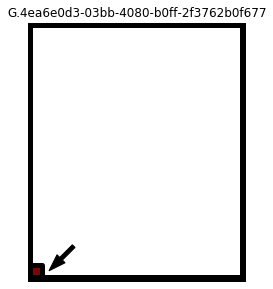

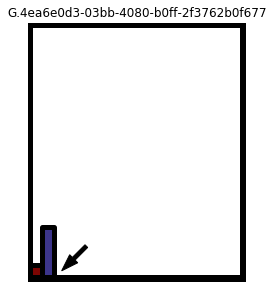

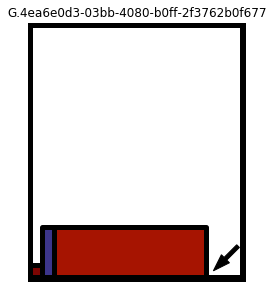

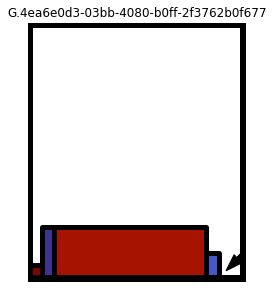

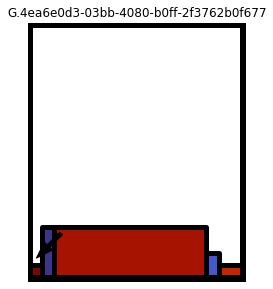

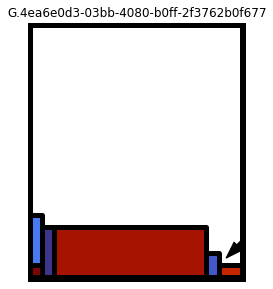

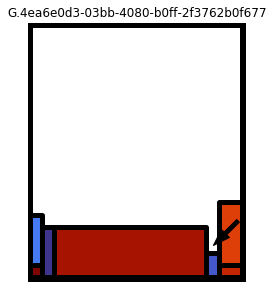

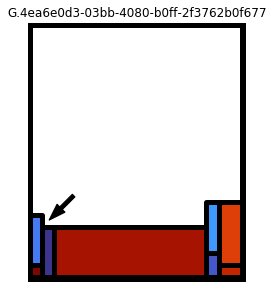

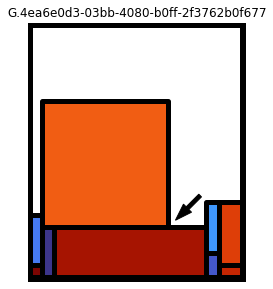

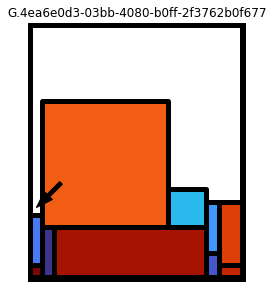

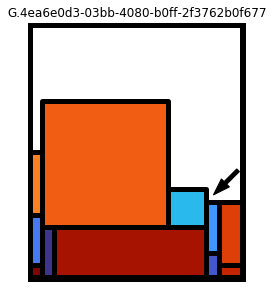

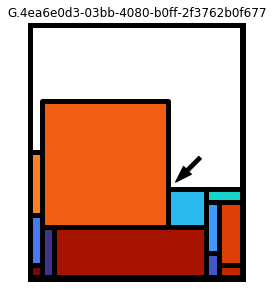

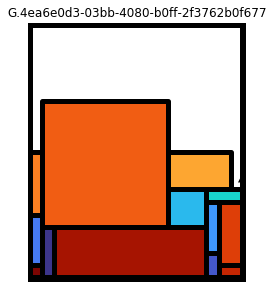

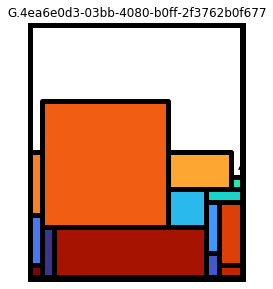

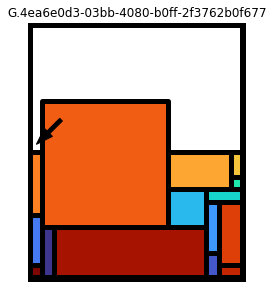

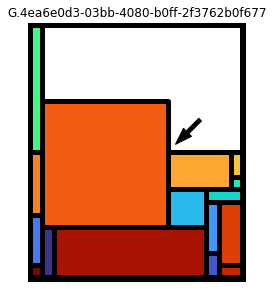

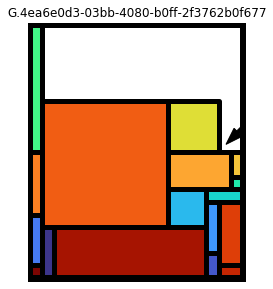

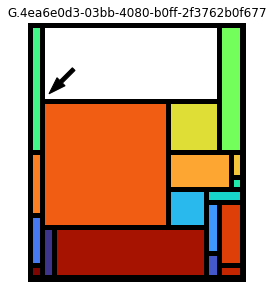

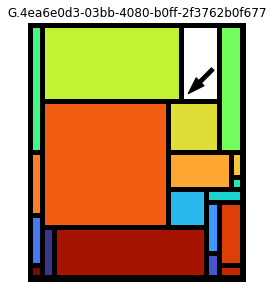

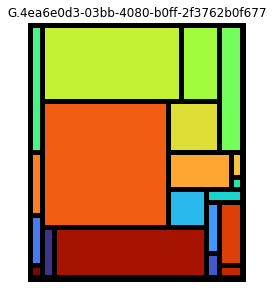

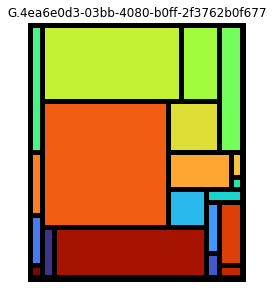

In [77]:
import datetime, json
from solution_checker import SolutionChecker
problems = Result.objects.filter(
    created_on__gte=datetime.datetime(2020, 3, 15), solution_found=True, score=0,
    their_id__in=best_their_ids,
    n_tiles=20, problem_generator='florian', solution_tiles_order__isnull=False).order_by('-created_on')
print(problems.count())


def visualize_problem_from_tiles(problem):
    grid = np.zeros((problem.rows, problem.cols))
    tiles = json.loads(problem.solution_tiles_order)
    color_o, color_e = 1,20
    lines = []
    alternate_colors = True
    if problem.problem_id:
        title = 'G.' + problem.problem_id
    else:
        title = f'B.{problem.their_id}'
    for i, tile in enumerate(tiles):
        if alternate_colors:
            if i % 2 == 0:
                color = color_o
                color_o += 1
            else:
                color = color_e
                color_e -= 1
        else:
            color = color_o
            color_o += 1
        next_lfb = SolutionChecker.get_next_lfb_on_grid(grid)
        #print(grid, tiles)
        success, grid = SolutionChecker.place_element_on_grid_given_grid(
            tile, next_lfb, color, grid, problem.cols, problem.rows)

        y, x = next_lfb
        lines.append([(x, y), (x+tile[1], y), (x + tile[1], y + tile[0]), (x, y+tile[0])])
        next_lfb = SolutionChecker.get_next_lfb_on_grid(grid)
        visualize_grid(grid, problem.rows, problem.cols, lines, next_lfb, title, i, problem.n_tiles_placed)
    visualize_grid(grid, problem.rows, problem.cols, lines, title=title, hardness=problem.n_tiles_placed)
#visualize_problem_from_tiles(problem)


results = Result.objects.filter(
    n_tiles=20, score=0,
    solution_tiles_order__isnull=False,
    problem_generator='florian',
    strategy='max_depth',
    #heir_id__in=best_their_ids,
    their_id=22803,
    solution_found=True).order_by('-n_tiles_placed')

results = Result.objects.filter(
    n_tiles=20, score=0, problem_generator='guillotine',
    problem_id__in=best_problem_ids,
    problem_id='4ea6e0d3-03bb-4080-b0ff-2f3762b0f677',
    n_simulations=5000,
    solution_found=True).order_by('n_tiles_placed')
problems_seen = set()
count = 0

for problem in results:
    if count == 10:
        break
    #f problem.cols >problem.rows:
    #   continue
    if problem.problem_id:
        if problem.problem_id in problems_seen:
            continue
        else:
            problems_seen.add(problem.problem_id)
    else:
        if problem.their_id in problems_seen:
            continue
        else:
            problems_seen.add(problem.their_id)
    
    print(problem.n_tiles_placed, problem.cols, problem.rows)
    print(problem.their_id, problem.rows, problem.cols, problem.n_simulations, problem.strategy)
    #visualize_problem_from_tiles(problem)
    try:
        visualize_problem_from_tiles(problem)
        count+=1
    except Exception as e:
        #print(e, exc_info=True)
        print(e)
        pass

In [ ]:
problems
print(problems.first().tiles)
len(json.loads(problems.first().solution_tiles_order))


problems = Result.objects.filter(
    created_on__gte=datetime.datetime(2020, 3, 15),
    n_tiles=20, problem_generator='florian',  their_id=23240, n_simulations=2000, strategy='max_depth').order_by('created_on')
problems.values()
    
problems.values()

results = Result.objects.filter(
    n_tiles=20, score=0, problem_generator='florian',
    their_id__in=best_their_ids, solution_found=True
).order_by('-n_tiles_placed').values_list('their_id', flat=True)
print(set(list(results)))

In [286]:
results = Result.objects.filter(
    n_tiles=20, score=0, problem_generator='guillotine', problem_id__in=best_problem_ids,
    solution_found=True).order_by('-n_tiles_placed')
for r in results[:10]:
    print(r.id, r.n_tiles_placed, r.created_on)
    print(r.n_simulations, r.strategy, r.problem_id, r.solution_tiles_order)

57494 15917044 2020-03-18 07:42:03.645565+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de [[3, 22], [5, 22], [6, 10], [4, 5], [4, 4], [8, 3], [2, 9], [2, 5], [2, 1], [2, 3], [1, 5], [2, 5], [1, 5], [8, 22], [1, 10], [1, 5], [1, 7], [1, 5], [1, 9], [1, 8]]
107236 15917044 2020-03-18 21:01:57.370680+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de [[3, 22], [5, 22], [6, 10], [4, 5], [4, 4], [8, 3], [2, 9], [2, 5], [2, 1], [2, 3], [1, 5], [2, 5], [1, 5], [8, 22], [1, 10], [1, 5], [1, 7], [1, 5], [1, 9], [1, 8]]
159384 15917044 2020-03-29 11:38:05.925950+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de [[3, 22], [5, 22], [6, 10], [4, 5], [4, 4], [8, 3], [2, 9], [2, 5], [2, 1], [2, 3], [1, 5], [2, 5], [1, 5], [8, 22], [1, 10], [1, 5], [1, 7], [1, 5], [1, 9], [1, 8]]
51098 15917044 2020-01-23 05:27:17.409391+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de [[3, 22], [5, 22], [6, 10], [4, 5], [4, 4], [8, 3], [2, 9], [2, 5], [2, 1], [2, 3], [1, 5], [2, 5], 

In [162]:
results = Result.objects.filter(
    n_tiles=20, score=0, problem_generator='guillotine', problem_id__in=best_problem_ids, solution_found=True).order_by('-n_tiles_placed')
for r in results[:10]:
    print(r.id, r.n_tiles_placed, r.created_on)
    print(r.n_simulations, r.strategy, r.problem_id, r.solution_tiles_order)

57494 15917044 2020-03-18 07:42:03.645565+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de None
159384 15917044 2020-03-29 11:38:05.925950+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de None
107236 15917044 2020-03-18 21:01:57.370680+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de None
51098 15917044 2020-01-23 05:27:17.409391+00:00
5000 avg_depth 5f7a784a-7571-4a08-80b2-883c1cfc65de None
183901 13444800 2020-03-29 11:40:47.653512+00:00
5000 max_depth 141ae3b9-4101-482e-9e9e-5689bcfac6c7 None
131762 13444800 2020-03-18 21:03:37.630127+00:00
5000 max_depth 141ae3b9-4101-482e-9e9e-5689bcfac6c7 None
29898 13444800 2020-01-22 19:00:25.424718+00:00
5000 max_depth 141ae3b9-4101-482e-9e9e-5689bcfac6c7 None
82012 13444800 2020-03-18 07:44:57.395778+00:00
5000 max_depth 141ae3b9-4101-482e-9e9e-5689bcfac6c7 None
44613 13167823 2020-01-22 20:31:57.909773+00:00
5000 avg_depth e76ae306-e973-4394-b4a6-1f960954d6b2 None
60531 13167823 2020-03-18 07:42:23.700148+00:00
500

In [11]:
import json
from solution_checker import SolutionChecker
easy_ones = [
    'results/20.0_10_10__1000_tree.json',
    'results/20.0_20_13__1000_tree.json',
    'results/20.0_10_24__5000_tree.json',
    'results/20.0_11_11__5000_tree.json',
]
hard_b_ones =  [
    'results/20.0_15_28__5000_tree.json',
]
def visualize_problem(height, width):
    problem_file = easy_ones[0]
    #problem_file = hard_b_ones[0]
    with open(f'results/20.0_{width}_{height}__5000_tree.json', 'r') as f:
        tree = json.loads(f.read())

    import copy
    initial_grid = copy.deepcopy(tree['board'])
    print(len(initial_grid))
    color_o = 0
    tilesis_over = False
    color_switch = 0
    while True:
        color_switch += 1
        if color_switch % 2 == 0:
            color = color_e
            color_e -= 1
        else:
            color = 20 - color_o
            color_o += 1
        for i, row in enumerate(tree['board']):
            for j, col in enumerate(row):
                if initial_grid[i][j] == 0 and col == 1:
                    initial_grid[i][j] = color
        if color_switch == 3:
            '''
            the solution skips one state here. need to create it.
            we do it by iterating over the tile in LFB
            '''

            i = next_lfb[0]
            j = next_lfb[1]
            i1, j1 = SolutionChecker.get_next_lfb_on_grid(np.array(tree['board']))
            while initial_grid[i+1] == initial_grid[i+1][j1]:  # go all the way upto top
                i += 1
            if initial_grid[i+1][j] != initial_grid[i+1][j1]:
                if initial_grid[i+1][j] == 0:
                    # left tile is smaller
                    while initial_grid[i+1][j] == 0:
                        j += 1
                    col_to_point_on = j - 1
                else:
                    while initial_grid[i+1][j] != 0:
                        j += 1
                    col_to_point_on = j - 1
            if col_to_point_on:
                for _i in range(next_lfb[0], len(tree['board'])):
                    for _j in range(col_to_point_on, len(tree['board'][0])):
                        if initial_grid[_i][_j] != 0:
                            initial_grid[_i][_j] = color_o
                color_o += 1
            else:
                continue
        # visualize_grid(initial_grid, len(initial_grid), len(initial_grid[0]))

        next_lfb = SolutionChecker.get_next_lfb_on_grid(np.array(initial_grid))
        if is_over:
            break
        if tree['children']:
            is_over=True
            for child in tree['children']:
                if child['children']:
                    tree = child
                    is_over = False
                    break
            # print(color)
            #print(tree['board'])
            # visualize_grid(initial_grid, len(initial_grid), len(initial_grid[0]))
        else:
            #print(initial_grid, color)
            #print(tree['board'])
            break

    visualize_grid(initial_grid, len(initial_grid), len(initial_grid[0]))

        # tree = child
        #if child['children']:
        #    tree = child


In [12]:
'''
Output just problems to csvs
'''
g_problems = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles')

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')

print(len(b_problems))
       
import csv, os
for file_name, problems in [('problems_g.csv', g_problems), ('problems_b.csv', b_problems)]:
    seen_rows =[]
    with open(os.path.join('problems/', file_name), 'w') as csv_file:
        fieldnames = ['rows', 'cols', 'tiles', 'n_tiles']
        if file_name == 'problems_b.csv':
            fieldnames.append('external_id')
        csv_writer = csv.writer(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
        csv_writer.writerow(fieldnames)
        for problem in problems:
            row = [problem['rows'], problem['cols'],
                   str(eliminate_duplicate_tiles(problem['tiles'])), problem['n_tiles']]
            if file_name == 'problems_b.csv':
                row.append(problem['their_id'])
            if row in seen_rows:
                continue
                
            seen_rows.append(row)
            
            csv_writer.writerow(row)


2886


NameError: name 'eliminate_duplicate_tiles' is not defined

In [118]:
'''
Output problems to F. Braam solver csv style
'''
import csv
#g_problems = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
#                                   improved_sel=True, strategy='max_depth', score__isnull=False,
#                                   solution_tiles_order__isnull=True,
#                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'problem_id', 'id')
b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                   improved_sel=True, strategy='max_depth', score__isnull=False,
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id', 'id')
# already_solved_ids = set()
# already_solved_ids = set()
# with open('g_solved_by_exhaustive_solver_filtered.csv', 'r') as f:
#     spamreader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_ALL)
#     for i, l in enumerate(spamreader):
#         if i == 0:
#             continue
#         puzzle_id = l[0]
#         already_solved_ids.add(int(puzzle_id))

# unsolved_ids = set()
# with open('unsolved_problems', 'r') as f:
#     spamreader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_ALL)
#     for i, l in enumerate(spamreader):
#         puzzle_id = l[0]
#         unsolved_ids.add(int(puzzle_id))
#         
# unsolved_problem_ids = set(Result.objects.filter(id__in=unsolved_ids).values_list('problem_id', flat=True))
#     
# print(len(unsolved_ids), len(b_problems))
import json
def tiles_to_braam_json(tiles):
    _tiles = []
    for tile in tiles:
        x = tile[0]
        y = tile[1]
        if tile[0] > tile[1]:
            x = tile[0]
            y = tile[1]
        else:
            x = tile[1]
            y = tile[0]
        _tiles.append({'X': x, 'Y': y})
    _tiles_str = json.dumps(_tiles)
    _tiles_str =  _tiles_str.replace(' ', '')
    return _tiles_str
    
import csv, os
for file_name, problems in [('problems_b_braam.csv', b_problems)]:
    with open(os.path.join('problems/', file_name), 'w') as csv_file:
        fieldnames = ['job_id', 'puzzle_id', 'num_tiles', 'board_width', 'board_height', 'tiles', 'start', 'end', 'their_id']
        csv_writer = csv.writer(csv_file, delimiter=',' , quoting=csv.QUOTE_ALL)
        csv_writer.writerow(fieldnames)
        for i, problem in enumerate(problems):
            # if problem['problem_id'] not in unsolved_problem_ids:
            #     continue
            # else:
            #     print(i, problem['problem_id'])
            tiles = eliminate_duplicate_tiles(problem['tiles'])
            tiles = tiles_to_braam_json(tiles)
            row = [
                problem['id'], problem['id'], problem['n_tiles'],
                problem['rows'], problem['cols'],
                   tiles,
                "", "", problem['their_id']
            ]
            csv_writer.writerow(row)


In [119]:
'''
Output problems with results to csv
'''

N_SIM = [100, 200, 500, 1000, 2000, 5000]

import csv, os
for file_name in ['results_g.csv', 'results_b.csv']:
    # find same problem instances
    with open(os.path.join('csv_results/', file_name), 'w') as csv_file:
        print('*' * 50)
        fieldnames = ['rows', 'cols', 'tiles', 'n_tiles',
                      'strategy', 'n_simulations', 'score',
                      'solution_found',  'n_tiles_placed', 'created_on']
        if file_name == 'results_b.csv':
            fieldnames.append('external_id')
        csv_writer = csv.writer(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
        csv_writer.writerow(fieldnames)
        for n_sim in N_SIM:
            if file_name == 'results_g.csv':
                problems = Result.objects.filter(
                    problem_id__in=best_problem_ids, n_simulations=n_sim, 
                    improved_sel=True, score__isnull=False
                ).values()
            else:
                problems = Result.objects.filter(
                    their_id__in=best_their_ids, n_simulations=n_sim, 
                    improved_sel=True, score__isnull=False
                ).values()

            for problem in problems:
                row = [problem['rows'], problem['cols'],
                       str(eliminate_duplicate_tiles(problem['tiles'])), problem['n_tiles']]
                for fieldname in fieldnames[4:-1]:
                    row.append(problem[fieldname])
                if file_name == 'results_b.csv':
                    row.append(problem['their_id'])
                csv_writer.writerow(row)


**************************************************
**************************************************


1000
1000
<class 'django.db.models.query.QuerySet'>


Text(0.5, 51.0, 'columns')

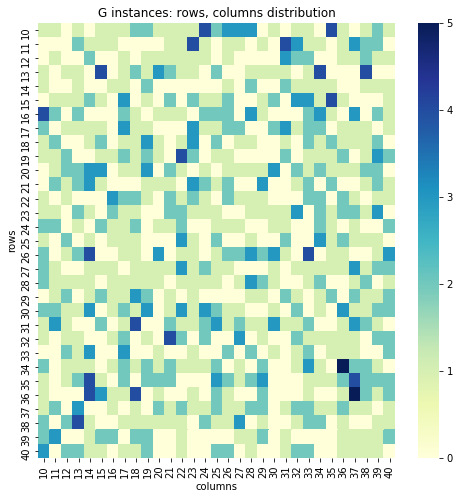

In [14]:
import pandas as pd
print(len(best_problem_ids))
rows_cols = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols')
print(len(rows_cols))
print(type(rows_cols))
rows_cols = [{'rows': x['rows'], 'cols': x['cols']} for x in rows_cols]
df = pd.DataFrame(rows_cols)
matrix = np.zeros((41, 41))
for v in rows_cols:
    matrix[v['rows'], v['cols']] += 1
matrix = matrix[10:, 10:]
plt.figure(figsize=(8,8))
plt.title('G instances: rows, columns distribution')
pd = pd.DataFrame(matrix, columns=range(10, 41), index=range(10, 41))
sns.heatmap(pd, cmap='YlGnBu')
plt.ylabel('rows')
plt.xlabel('columns')

In [15]:
tiles = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('tiles')

from collections import defaultdict
tiles_count = defaultdict(int)
for tile_dict in tiles:
    _tiles = tile_dict['tiles']
    for one_tile in _tiles:
        if one_tile[0] == one_tile[1]:
            tiles_count[(one_tile[0], one_tile[1])] += 1
            
print('Count of squares in problems:', tiles_count)

            
    
    

Count of squares in problems: defaultdict(<class 'int'>, {(1, 1): 5542, (4, 4): 238, (2, 2): 482, (8, 8): 44, (3, 3): 134, (6, 6): 88, (9, 9): 38, (5, 5): 72, (7, 7): 46, (14, 14): 18, (20, 20): 2, (10, 10): 12, (13, 13): 8, (16, 16): 20, (12, 12): 4, (24, 24): 2, (11, 11): 6, (21, 21): 2, (15, 15): 8, (22, 22): 2, (18, 18): 2, (17, 17): 2})


In [14]:
print(len(best_problem_ids))
print(len(best_their_ids))

1000
1000


In [17]:
'''
How many problems have duplicate tiles?
How many problems have squares?
How many problems have tiles bigger than col or width?
'''

from collections import defaultdict
def has_squares(tiles, with_1_1=False):
    for tile in tiles:
        if tile[0] == tile[1]:
            if with_1_1 and tile[0] == 1:
                continue
            else:
                return True
    return False

def has_duplicates(tiles, ignore_squares=False):
    tiles_count = defaultdict(int)
    for tile in tiles:
        str_tile = str(tile)
        tiles_count[str_tile] += 1
        if tiles_count[str_tile] > 2 and tile[0] == tile[1]:
            return True
        if tiles_count[str_tile] > 1 and tile[0] != tile[1]:
            return True
    return False

def has_tile_bigger_than_width_height(tiles, rows, cols):
    for tile in tiles:
        if tile[0] > rows or tile[1] > cols or tile[0] > cols or tile[1] > rows:
            return True
    return False

In [18]:
common_args = {'problem_generator': 'guillotine', 'improved_sel': True, 'n_simulations': 1000}
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args)
distinct_problems = g_max_depth_instances.values('tiles', 'cols', 'rows').distinct()

n_with_squares = 0
n_with_squares_excluding_1_1 = 0
n_with_duplicates = 0
n_with_duplicates_ign_s = 0
n_tile_bigger_than_width_height = 0
n_frames_that_cannot_accomodate = 0
computed_problems = set()
for problem in distinct_problems:
    problem_str = (problem['cols'], problem['rows'], str(problem['tiles']))
    if problem_str in computed_problems:
        continue
    else:
        computed_problems.add(problem_str)
    if has_squares(problem['tiles']):
        n_with_squares += 1
    if has_squares(problem['tiles'], with_1_1=True):
        n_with_squares_excluding_1_1 += 1
    if has_duplicates(problem['tiles']):
        n_with_duplicates += 1
    if has_duplicates(problem['tiles'], ignore_squares=True):
        n_with_duplicates_ign_s += 1
    if has_tile_bigger_than_width_height(problem['tiles'], problem['rows'], problem['cols']):
        n_frames_that_cannot_accomodate += 1
    
print(f'G problems with squares: {n_with_squares}')
print(f'G problems with squares (ignoring (1, 1) tile): {n_with_squares_excluding_1_1}')
print(f'G problems with duplicate tiles: {n_with_duplicates}')
print('G problems with frames that cannot accomodate '
      f'all tiles both horizontally and vertically: {n_frames_that_cannot_accomodate}')

G problems with squares: 941
G problems with squares (ignoring (1, 1) tile): 429
G problems with duplicate tiles: 1000
G problems with frames that cannot accomodate all tiles both horizontally and vertically: 607


In [19]:
def visualize_qs(qs):
    for p in qs:
        try:
            print(p.rows, p.cols)
            visualize_problem(p.rows, p.cols)
        except Exception as e:
            print(f'Exceeption {e} occurred')

In [20]:
'''
Finding the hardest problems for 5000 simulations
'''
def print_scores(scores):
    for p in scores:
        print(f'(score)unplaced_tiles: {p.score}; placed_tiles: {p.n_tiles_placed}; height: {p.rows}; width: {p.cols}; tiles: {p.tiles}')
    
common_args = {'problem_generator': 'guillotine', 'improved_sel': True, 'n_simulations': 5000}

g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', score__isnull=False, **common_args)
g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', score__isnull=False, **common_args)

max_depth_worst_score = g_max_depth_instances.order_by('score').last().score
avg_depth_worst_score = g_avg_depth_instances.order_by('score').last().score

g_max_depth_instances = g_max_depth_instances.filter(score=max_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest G max_depth problems:')
print_scores(g_max_depth_instances)
print()
g_avg_depth_instances = g_avg_depth_instances.filter(score=avg_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest G avg_depth problems:')
print_scores(g_avg_depth_instances)

print()
print('Easiest 3 G avg_depth problems:')
g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_avg_depth_instances[:3])

print()
print('Easiest 3 G max_depth problems:')
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_max_depth_instances[:20])
visualize_qs(g_avg_depth_instances[:20])

print()
print('Hardest solved G max_depth problems:')
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', solution_found=True, score=0, **common_args).order_by('-n_tiles_placed')
visualize_qs(g_max_depth_instances[:40])

print('*' * 100)
print('Hardest solved G avg_depth problems:')
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', solution_found=True, score=0, **common_args).order_by('-n_tiles_placed')
visualize_qs(g_max_depth_instances[:40])


print()
print('Interestingly the easiest avg_depth and max_depth problems have same number of placed_tiles (for upto 326 easiest problems) which means the strategies do not make a difference during the search.')

Hardest G max_depth problems:
(score)unplaced_tiles: 3.0; placed_tiles: 14753004; height: 27; width: 36; tiles: [[1, 1], [1, 1], [1, 1], [1, 1], [5, 1], [7, 1], [9, 1], [10, 1], [10, 1], [11, 1], [14, 1], [16, 1], [16, 1], [36, 1], [2, 2], [2, 2], [3, 2], [21, 2], [2, 3], [5, 3], [9, 3], [17, 3], [1, 5], [3, 5], [1, 7], [36, 8], [1, 9], [3, 9], [1, 10], [1, 10], [1, 11], [31, 13], [1, 14], [1, 16], [1, 16], [3, 17], [2, 21], [13, 31], [1, 36], [8, 36]]
(score)unplaced_tiles: 3.0; placed_tiles: 10670831; height: 19; width: 40; tiles: [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [6, 1], [20, 1], [35, 1], [1, 2], [6, 2], [6, 2], [14, 2], [20, 2], [35, 2], [3, 3], [3, 3], [5, 3], [10, 4], [3, 5], [8, 5], [1, 6], [2, 6], [2, 6], [17, 6], [5, 8], [4, 10], [16, 10], [15, 11], [2, 14], [11, 15], [10, 16], [6, 17], [1, 20], [2, 20], [1, 35], [2, 35]]

Hardest G avg_depth problems:
(score)unplaced_tiles: 4.0; placed_tiles: 12612987; height: 16; width: 33; tiles: [[1, 

Exceeption [Errno 2] No such file or directory: 'results/20.0_10_13__5000_tree.json' occurred
21 13
21
Exceeption local variable 'is_over' referenced before assignment occurred
10 10
10
Exceeption local variable 'is_over' referenced before assignment occurred
38 34
38
Exceeption local variable 'is_over' referenced before assignment occurred
35 29
35
Exceeption local variable 'is_over' referenced before assignment occurred
11 13
11
Exceeption local variable 'is_over' referenced before assignment occurred
25 16
Exceeption [Errno 2] No such file or directory: 'results/20.0_16_25__5000_tree.json' occurred
16 35
16
Exceeption local variable 'is_over' referenced before assignment occurred
19 39
19
Exceeption local variable 'is_over' referenced before assignment occurred
31 15
31
Exceeption local variable 'is_over' referenced before assignment occurred
16 13
16
Exceeption local variable 'is_over' referenced before assignment occurred
10 28
10
Exceeption local variable 'is_over' referenced bef

35
Exceeption local variable 'is_over' referenced before assignment occurred

Interestingly the easiest avg_depth and max_depth problems have same number of placed_tiles (for upto 326 easiest problems) which means the strategies do not make a difference during the search.


In [21]:
common_args = {'problem_generator': 'florian', 'improved_sel': True, 'n_simulations': 5000, 'their_id__in':best_their_ids}

g_max_depth_instances = Result.objects.filter(strategy='max_depth', score__isnull=False, **common_args)
g_avg_depth_instances = Result.objects.filter(strategy='avg_depth', score__isnull=False, **common_args)

max_depth_worst_score = g_max_depth_instances.order_by('score').last().score
avg_depth_worst_score = g_avg_depth_instances.order_by('score').last().score

g_max_depth_instances = g_max_depth_instances.filter(score=max_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest B max_depth problems:')
print_scores(g_max_depth_instances)
print()
g_avg_depth_instances = g_avg_depth_instances.filter(score=avg_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest B avg_depth problems:')
print_scores(g_avg_depth_instances)

print()
print('Easiest 3 B avg_depth problems:')
g_avg_depth_instances = Result.objects.filter(strategy='avg_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_avg_depth_instances[:3])
visualize_qs(g_avg_depth_instances[:10])

print()
print('Easiest 3 B max_depth problems:')
g_max_depth_instances = Result.objects.filter(strategy='max_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_max_depth_instances[:3])
visualize_qs(g_max_depth_instances[:10])

Hardest B max_depth problems:
(score)unplaced_tiles: 4.0; placed_tiles: 9186851; height: 44; width: 59; tiles: [[21, 1], [22, 1], [3, 2], [10, 2], [19, 2], [22, 2], [2, 3], [7, 4], [14, 4], [18, 4], [8, 5], [14, 6], [4, 7], [21, 7], [5, 8], [14, 9], [2, 10], [15, 12], [19, 12], [19, 13], [4, 14], [6, 14], [9, 14], [18, 14], [26, 14], [12, 15], [19, 15], [21, 16], [4, 18], [14, 18], [2, 19], [12, 19], [13, 19], [15, 19], [1, 21], [7, 21], [16, 21], [1, 22], [2, 22], [14, 26]]
(score)unplaced_tiles: 4.0; placed_tiles: 8109917; height: 51; width: 78; tiles: [[13, 1], [22, 2], [9, 3], [12, 3], [15, 4], [11, 5], [17, 5], [23, 5], [17, 6], [13, 7], [22, 7], [3, 9], [11, 10], [5, 11], [10, 11], [3, 12], [1, 13], [7, 13], [15, 13], [4, 15], [13, 15], [20, 15], [5, 17], [6, 17], [23, 17], [21, 18], [22, 18], [23, 19], [15, 20], [18, 21], [23, 21], [2, 22], [7, 22], [18, 22], [23, 22], [5, 23], [17, 23], [19, 23], [21, 23], [22, 23]]
(score)unplaced_tiles: 4.0; placed_tiles: 7856432; height: 47;

In [22]:
common_args = {'problem_generator': 'florian', 'improved_sel': True}

N_SIM = [100, 200, 500, 1000, 2000, 5000]

# find same problem instances
for n_sim in N_SIM:
    print('*' * 50)
    print(f'SIMULATIONS: {n_sim}')
    print('*' * 50)
    common_args['problem_generator'] = 'guillotine'
    common_args['n_simulations'] = n_sim
    common_args['score__isnull'] = False

    g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args)
    g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args)

    print('Guillotine:')
    calc_p_value(Result.objects.filter(problem_id__in=best_problem_ids, **common_args), g_max_depth_instances, g_avg_depth_instances)

    common_args['problem_generator'] = 'florian'
    ng_avg_depth_instances = Result.objects.filter(strategy='avg_depth', their_id__in=best_their_ids,  **common_args)
    ng_max_depth_instances = Result.objects.filter(strategy='max_depth', their_id__in=best_their_ids, **common_args)
    ng_avg_depth_scores = ng_avg_depth_instances.values('score')
    ng_max_depth_scores = ng_max_depth_instances.values('score')

    print('Non-guillotine:')
    calc_p_value(Result.objects.filter(**common_args), ng_max_depth_instances, ng_avg_depth_instances, is_guillotine=False)

    # scores = results.values('score', 'strategy')
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='avg_depth', **common_args).values_list('rows', flat=True))))
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='max_depth', **common_args).values_list('rows', flat=True))))

**************************************************
SIMULATIONS: 100
**************************************************
Guillotine:
In total max_depth_wins: 143, avg_depth_wins: 255, and 602 ties.
p value: 2.1454018128589555e-08
Non-guillotine:
In total max_depth_wins: 461, avg_depth_wins: 147, and 392 ties.
p value: 1.1721393347580135e-38
**************************************************
SIMULATIONS: 200
**************************************************
Guillotine:
In total max_depth_wins: 158, avg_depth_wins: 226, and 616 ties.
p value: 0.0006100659426685002
Non-guillotine:
In total max_depth_wins: 519, avg_depth_wins: 127, and 354 ties.
p value: 4.058279577695039e-57
**************************************************
SIMULATIONS: 500
**************************************************
Guillotine:
In total max_depth_wins: 164, avg_depth_wins: 197, and 639 ties.
p value: 0.09200296366604292
Non-guillotine:
In total max_depth_wins: 574, avg_depth_wins: 103, and 323 ties.
p value: 3.890

In [39]:
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

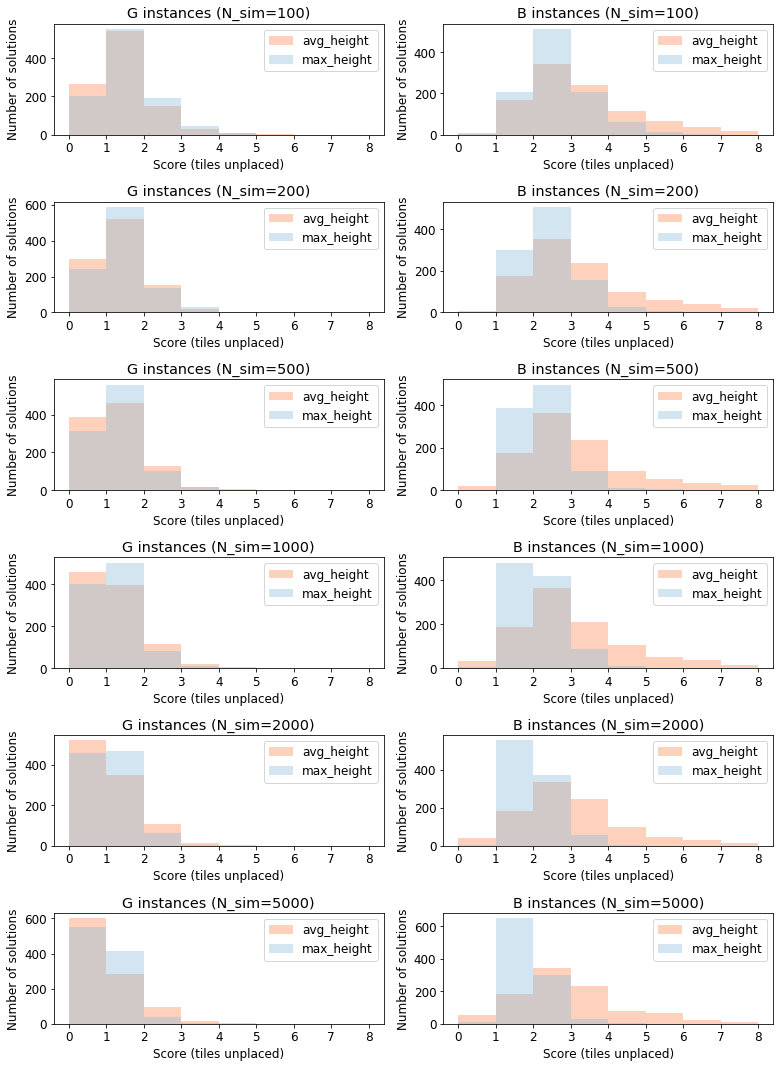

In [105]:
# scores_df
N_SIM = [100, 200, 500, 1000, 2000, 5000]
plt.rcParams.update({'font.size': 12})
f, axes = plt.subplots(len(N_SIM), 2, figsize=(11, 15))
for j, n_sim in enumerate(N_SIM):
    common_args = {
        'score__isnull': False, 'improved_sel': True,
        'n_simulations': n_sim
    }
    bins = np.arange(0, 9)
    rows = len(N_SIM) // 2
    for i in range(2):
        if i == 0:
            common_args['problem_generator'] = 'guillotine'
            title = f'G instances (N_sim={n_sim})'
            avg_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args).values('score')
        else:
            title = f'B instances (N_sim={n_sim})'
            common_args['problem_generator'] = 'florian'
            avg_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='max_depth', **common_args).values('score')

        sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)),
                     kde=False, color='#fc8d59', label='avg_height', bins=bins, ax=axes[j][i])
        sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)),
                          kde=False, color='#91bfdb', label='max_height', bins=bins, ax=axes[j][i])
        axes[j][i].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[j][i].xaxis.set_major_formatter(ticker.ScalarFormatter())
        # plt.xlim(left=i)
        axes[j][i].set_ylabel('Number of solutions')
        axes[j][i].set_xlabel('Score (tiles unplaced)')
        axes[j][i].set_title(title)
        axes[j][i].legend()
        
f.tight_layout()
# plt.rcParams["figure.figsize"] = (8,5)
plt.show()

100;max_depth;guillotine;1.1111111111111112;1.0;0.8074469690836864
100;avg_depth;guillotine;0.973;1.0;0.793032092604013
200;max_depth;guillotine;0.9719719719719719;1.0;0.7485558676472942
200;avg_depth;guillotine;0.91;1.0;0.761892696172158
500;max_depth;guillotine;0.837;1.0;0.7063497221135788
500;avg_depth;guillotine;0.791;1.0;0.7745443298604149
1000;max_depth;guillotine;0.701;1.0;0.6648616706060299
1000;avg_depth;guillotine;0.716;1.0;0.8012402798074907
2000;max_depth;guillotine;0.621;1.0;0.6494465187994933
2000;avg_depth;guillotine;0.633;0.0;0.7777634061306278
5000;max_depth;guillotine;0.4904904904904905;0.0;0.5782113076482024
5000;avg_depth;guillotine;0.541;0.0;0.7700077349688845


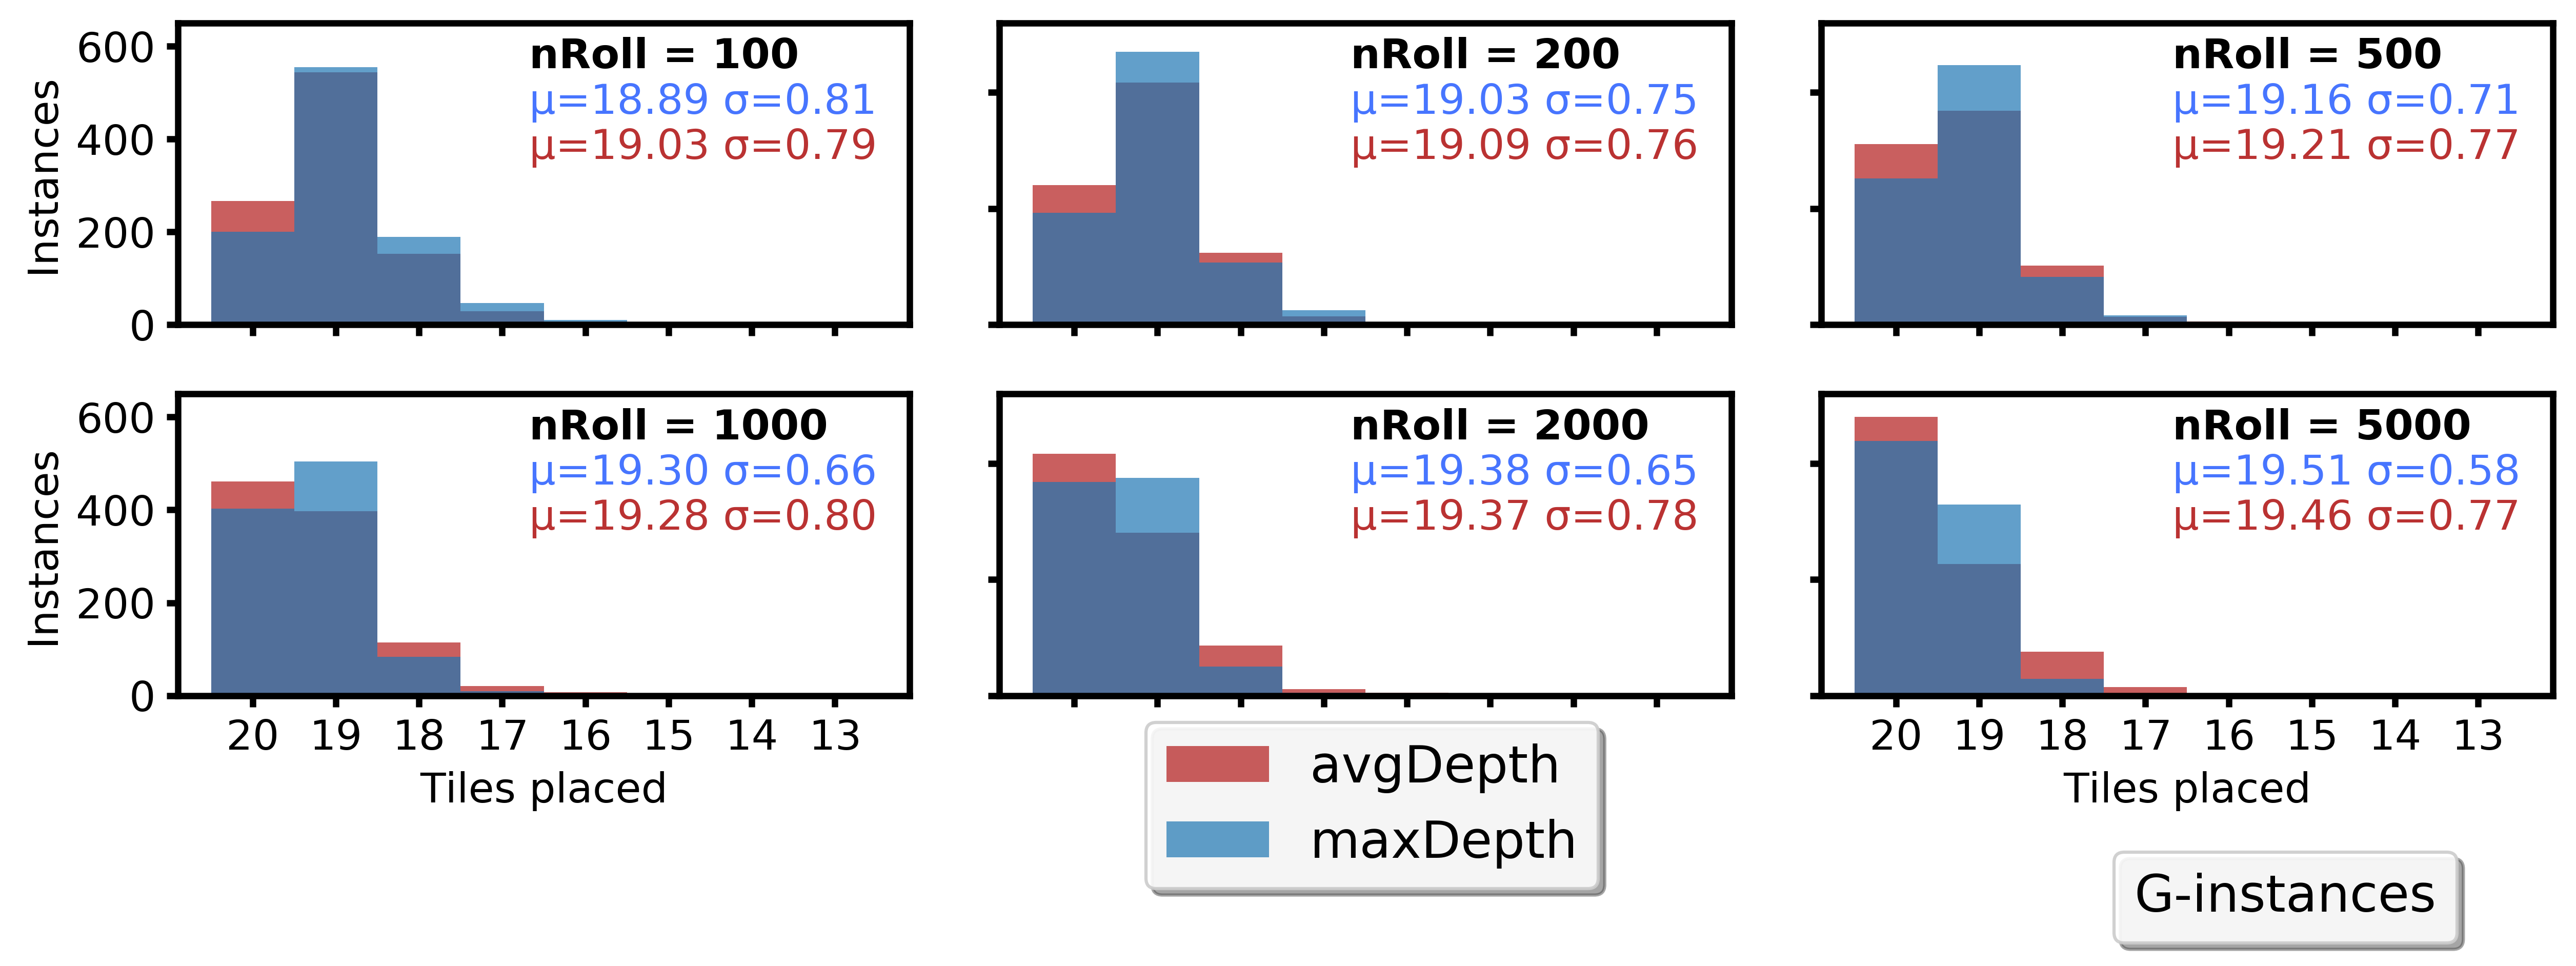

100;max_depth;florian;2.15;2.0;0.8650134381894008
100;avg_depth;florian;2.736;2.0;1.4534154314635634
200;max_depth;florian;1.937;2.0;0.8085076899354048
200;avg_depth;florian;2.728;2.0;1.5020893023626367
500;max_depth;florian;1.739;2.0;0.7206929987160957
500;avg_depth;florian;2.629;2.0;1.4844401512228653
1000;max_depth;florian;1.623;2.0;0.7038226810542314
1000;avg_depth;florian;2.559;2.0;1.4807807777357564
2000;max_depth;florian;1.506;1.0;0.657568548819358
2000;avg_depth;florian;2.544;2.0;1.4547096549415555
5000;max_depth;florian;1.358;1.0;0.5849599799799796
5000;avg_depth;florian;2.484;2.0;1.4696611527504915


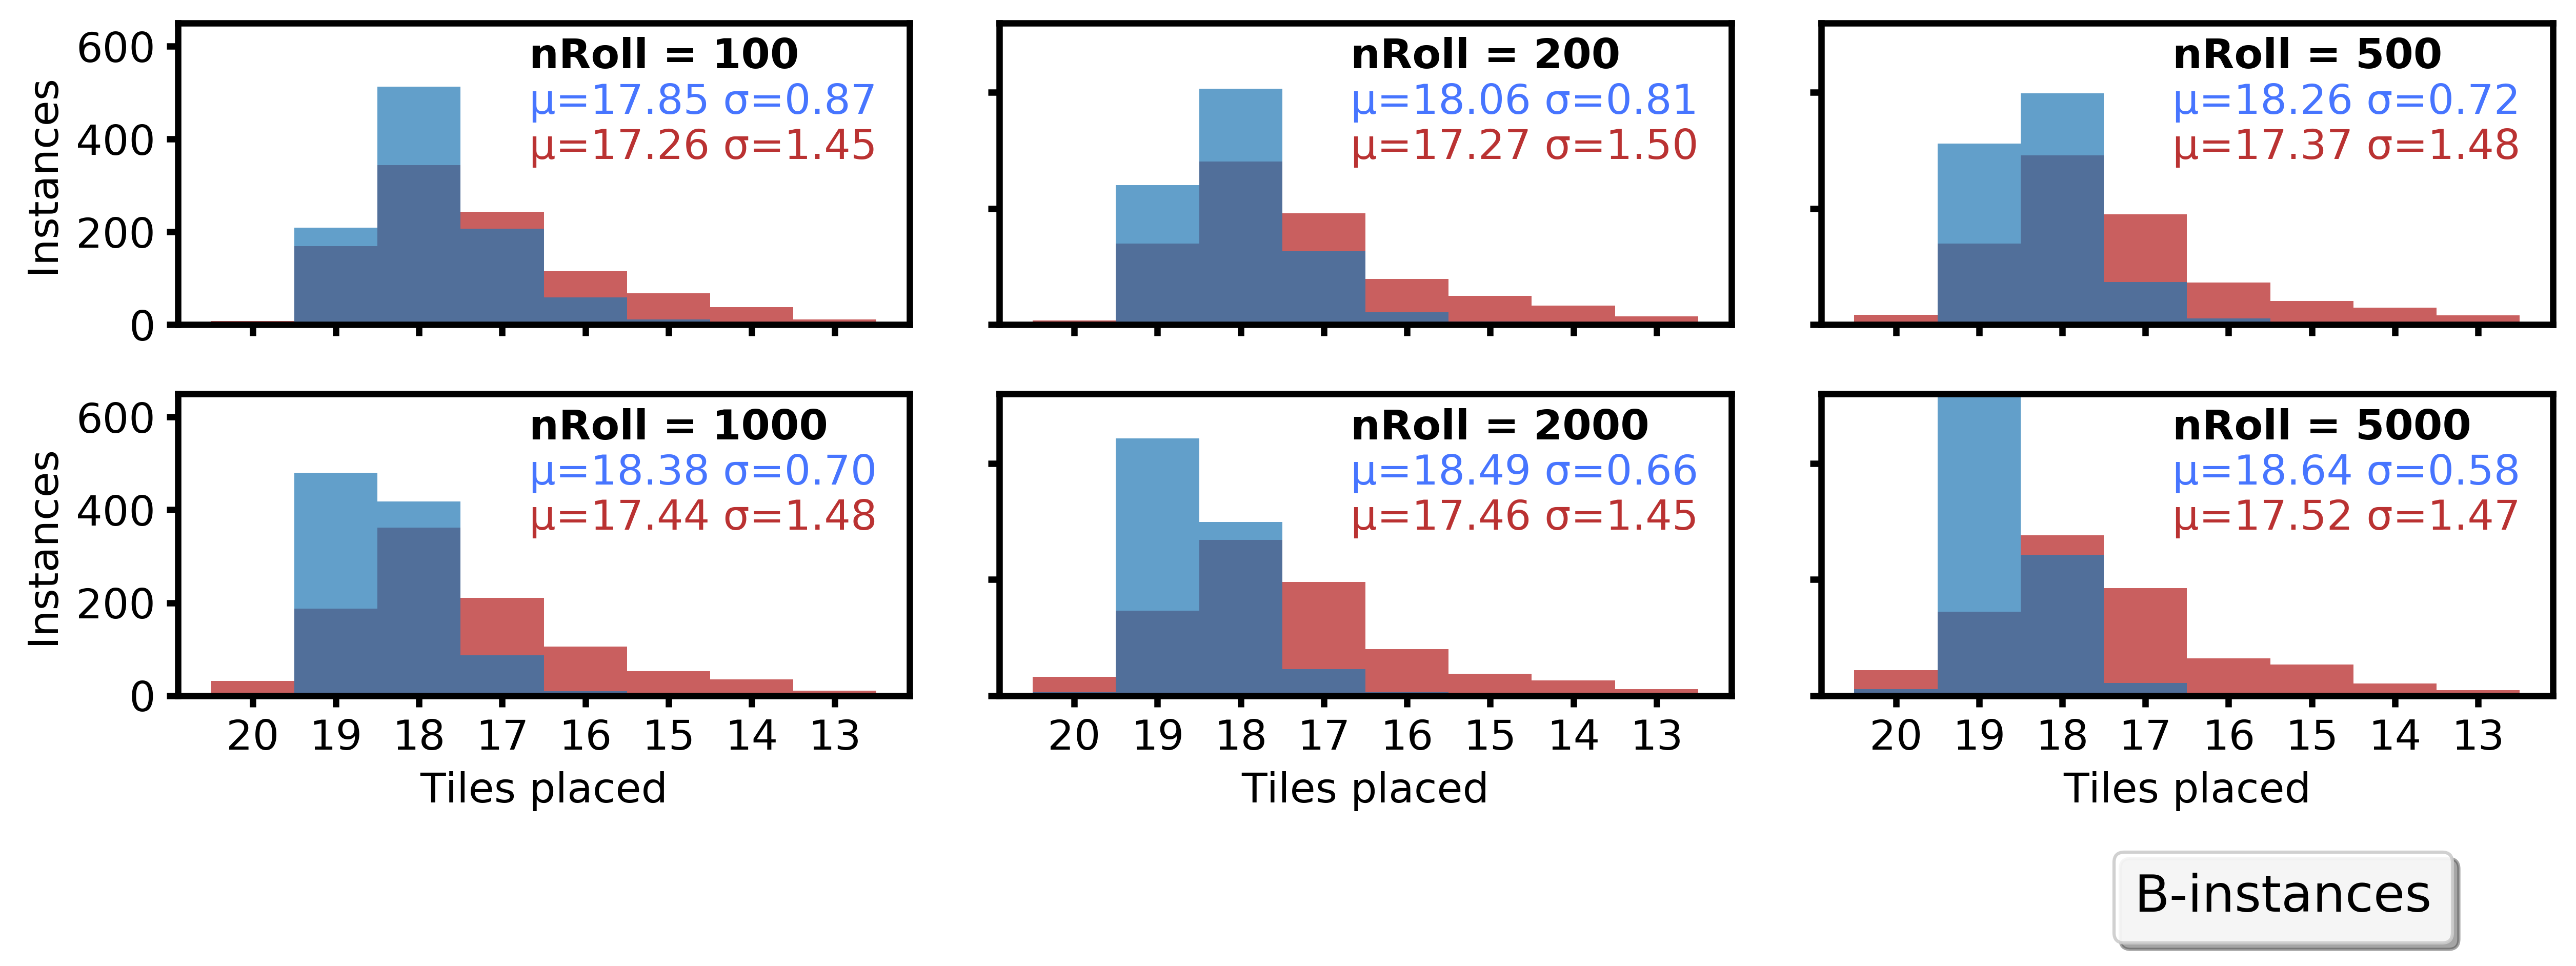

In [162]:
# scores_df
#f, axes = plt.subplots(4, 3, figsize=(11, 15))
from itertools import combinations
N_SIM = [100, 200, 500, 1000, 2000, 5000]
titles = {'guillotine': 'G-instances', 'florian': 'B-instances'}
plt.rcParams.update({'font.size': 13})
#colors = [ "#E64B35","#4DBBD5", "#00A087","#3C5488", "#F39B7F","#8491B4", "#91D1C2","#DC0000", "#7E6148","#B09C85" ]
colors = sns.color_palette()
# for color1, color2 in combinations(colors, 2):

for p_type_index, problem_type in enumerate(['guillotine', 'florian']):
    # plt.suptitle(titles[problem_type], y=1.02)
    f, axes = plt.subplots(2, 3, figsize=(11.5, 4.6), dpi=450)
    j = p_type_index
    bins = np.arange(0, 9) - 0.5
    rows = len(N_SIM) // 2
    _title = titles[problem_type]

    for j in range(2):
        for i in range(3):
            if j == 0:
                n_sim = N_SIM[i % 6]
            else:
                n_sim = N_SIM[(i + 3) % 6]
            common_args = {
                'score__isnull': False, 'improved_sel': True,
                'n_simulations': n_sim,
            }
            if problem_type == 'guillotine':
                common_args['problem_generator'] = 'guillotine'
                title = f'G instances (N_sim={n_sim})'
                avg_depth_scores = Result.objects.filter(
                    problem_id__in=best_problem_ids, strategy='avg_depth', **common_args).values('score')
                max_depth_scores = Result.objects.filter(
                    problem_id__in=best_problem_ids, strategy='max_depth', **common_args).values('score')
            else:
                title = f'B instances (N_sim={n_sim})'
                common_args['problem_generator'] = 'florian'
                avg_depth_scores = Result.objects.filter(their_id__in=best_their_ids,
                                                         strategy='avg_depth', **common_args).values('score')
                max_depth_scores = Result.objects.filter(their_id__in=best_their_ids,
                                                         strategy='max_depth', **common_args).values('score')

            avg_depth_scores_df = pd.DataFrame.from_records(avg_depth_scores)
            sns.distplot(score_to_int(avg_depth_scores_df),
                         kde=False, label='avgDepth',
                         color="#b31b1b",
                         hist_kws=dict(alpha=0.7),
                         bins=bins, ax=axes[j][i])
            max_depth_scores_df = pd.DataFrame.from_records(max_depth_scores)
            sns.distplot(score_to_int(max_depth_scores_df),
                              hist_kws=dict(alpha=0.7),
                              kde=False, label='maxDepth', bins=bins, ax=axes[j][i])

            axes[j][i].set_ylim(0, 650)
            axes[j][i].xaxis.set_major_locator(ticker.MultipleLocator(1))
            axes[j][i].xaxis.set_major_formatter(ticker.ScalarFormatter())
            # plt.xlim(left=i)
            title = f'nRoll = {n_sim}'

            
            
            # axes[j][i].axvline(mean - stddev, linestyle=':', color=color, label='$\sigma$')
            # axes[j][i].axvline(mean + stddev, linestyle=':', color=color)
            # axes[j][i].axvline(mean, color=color, label='$\mu$')

            #END MEAN AND STDDEV
            if j == 1 and  not (i == 1 and problem_type=='guillotine'):
                axes[j][i].set_xlabel('Tiles placed')
                axes[j][i].set_xticklabels([21, 20, 19, 18, 17, 16, 15, 14, 13])
            else:
                axes[j][i].set_xticklabels([])
                
            
            # MEAN AND STDDEV
                
            if i == 0:
                if problem_type == 'guillotine':
                    axes[j][i].set_ylabel(f'Instances')
                else:
                    axes[j][i].set_ylabel(f'Instances')
            if i > 0:
                axes[j][i].set_yticklabels([])
            else:
                pass
                # axes[j][i].set_yticklabels([0, 200, 400, 600])
                axes[j][i].locator_params(nbins=4, axis='y')
               
            if j == 1 and problem_type=='guillotine' and i == 1:
                axes[j][i].legend(loc=(0.2, -0.64), framealpha=0.9, shadow=True, fontsize=16)
            
            start_text = 0.48
            axes[j][i].text(start_text,.85,title,
                    horizontalalignment='left',
                    weight='bold',
                    transform=axes[j][i].transAxes)
            
            # MEAN AND STDDEV
            color = '#3366ff'
            mean = max_depth_scores_df['score'].mean()
            median = max_depth_scores_df['score'].median()
            stddev = max_depth_scores_df['score'].std()
            # axes[j][i].axvline(mean - stddev, linestyle=':', color=color)
            # axes[j][i].axvline(mean + stddev, linestyle=':', color=color)
            # axes[j][i].axvline(mean, color=color)
            print(f'{n_sim};max_depth;{problem_type};{mean};{median};{stddev}')
            
            axes[j][i].text(start_text, .70, 'μ={:.2f} σ={:.2f}'.format(20 - round(mean, 2), round(stddev, 2)),
                            horizontalalignment='left',
                            transform=axes[j][i].transAxes,
                            # weight='bold',
                            alpha=0.9,
                            color='#3366ff')

            color = '#b31b1b'
            mean = avg_depth_scores_df['score'].mean()
            median = avg_depth_scores_df['score'].median()
            stddev = avg_depth_scores_df['score'].std()
            print(f'{n_sim};avg_depth;{problem_type};{mean};{median};{stddev}')
            axes[j][i].text(start_text, .55, 'μ={:.2f} σ={:.2f}'.format(20 - round(mean, 2), round(stddev, 2)),
                            horizontalalignment='left',
                            transform=axes[j][i].transAxes,
                            #weight='bold',
                            alpha=0.9,
                            color='#b31b1b')
            
            if j == 1 and i == 2:
                handles, labels = axes[j][i].get_legend_handles_labels()
                handles = handles[::-1]
                labels = labels[::-1][:2]
                import matplotlib
                extra = matplotlib.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
                axes[j][i].legend([extra], [_title], loc=(0.4, -0.82),
                                  handlelength=0,
                                  handletextpad=0,
                                  framealpha=0.9, shadow=True, fontsize=16)

            plt.setp(axes[j][i].spines.values(), linewidth=2)
            axes[j][i].tick_params(width=2)
            

    f.tight_layout()
    # plt.rcParams["figure.figsize"] = (8,5)
    plt.savefig(f'12_{problem_type}.png', transparent=False)
    plt.show()

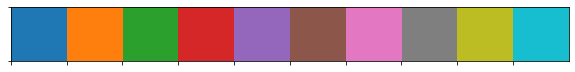

In [27]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
#print(current_palette)
for strategy in ['max_depth', 'avg_depth']:
    for n_sim in [100, 200, 500, 1000, 2000, 5000]:
        for r in Result.objects.filter(their_id__in=best_their_ids,
                      improved_sel=True,
                      strategy=strategy, n_simulations=n_sim
                     ):
            if Result.objects.filter(
                improved_sel=True, strategy=strategy, n_simulations=n_sim,
                their_id=r.their_id
            ).count() > 1:
                r.delete()


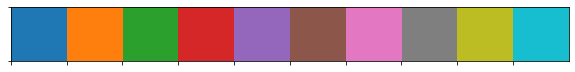

In [28]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
#print(current_palette)
for strategy in ['max_depth', 'avg_depth']:
    for n_sim in [100, 200, 500, 1000, 2000, 5000]:
        for r in Result.objects.filter(problem_id__in=best_problem_ids,
                      improved_sel=True,
                      strategy=strategy, n_simulations=n_sim
                     ):
            if Result.objects.filter(
                improved_sel=True, strategy=strategy, n_simulations=n_sim,
                problem_id=r.problem_id
            ).count() > 1:
                r.delete()

### Simulation runs vs score

avg_depth
100 1000
avg_depth
200 1000
avg_depth
500 1000
avg_depth
1000 1000
avg_depth
2000 1000
avg_depth
5000 1000
[0 1 2 3 4 5]
OrderedDict([(100, {'median score': 0.973, 'median tiles placed': 250534847, 'solutions found': 26.6}), (200, {'median score': 0.91, 'median tiles placed': 486259739, 'solutions found': 30.0}), (500, {'median score': 0.791, 'median tiles placed': 1095306143, 'solutions found': 38.9}), (1000, {'median score': 0.716, 'median tiles placed': 1987119667, 'solutions found': 46.1}), (2000, {'median score': 0.633, 'median tiles placed': 3577742373, 'solutions found': 52.1}), (5000, {'median score': 0.541, 'median tiles placed': 7460459402, 'solutions found': 60.099999999999994})]) g
26.6	250534847
30.0	486259739
38.9	1095306143
46.1	1987119667
52.1	3577742373
60.099999999999994	7460459402
Number of tiles non-placed in correlation with simulation runs


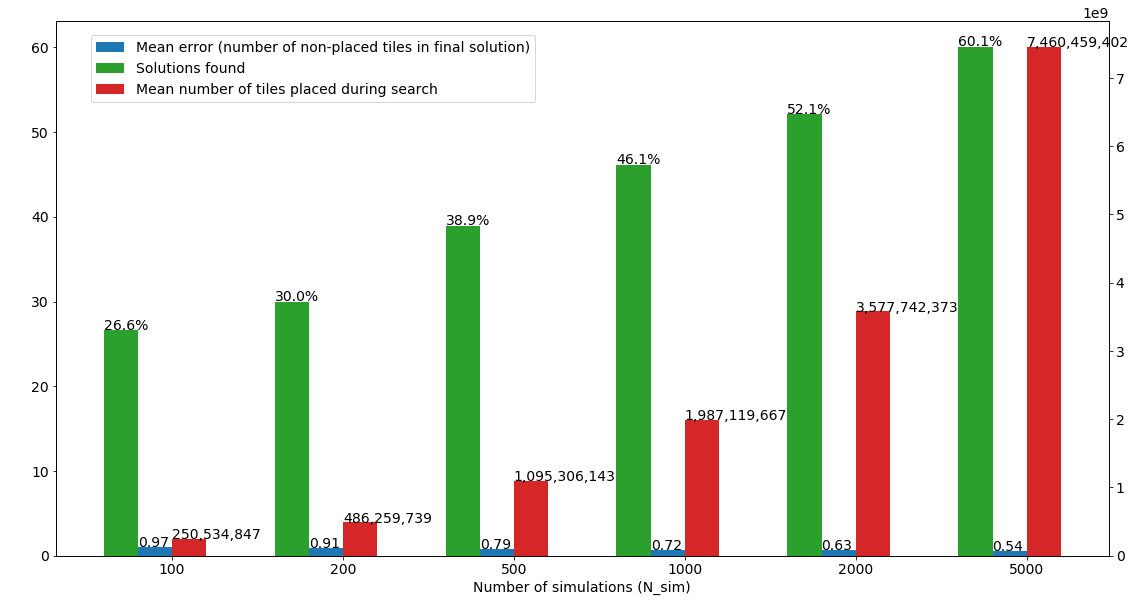

avg_depth
100 1000
avg_depth
200 1000
avg_depth
500 1000
avg_depth
1000 1000
avg_depth
2000 1000
avg_depth
5000 1000
[0 1 2 3 4 5]
OrderedDict([(100, {'median score': 2.736, 'median tiles placed': 256278482, 'solutions found': 0.8}), (200, {'median score': 2.728, 'median tiles placed': 518082673, 'solutions found': 0.8999999999999999}), (500, {'median score': 2.629, 'median tiles placed': 1304127579, 'solutions found': 2.1}), (1000, {'median score': 2.559, 'median tiles placed': 2607250826, 'solutions found': 3.2}), (2000, {'median score': 2.544, 'median tiles placed': 5203417411, 'solutions found': 4.0}), (5000, {'median score': 2.484, 'median tiles placed': 12905554577, 'solutions found': 5.5})]) b
0.8	256278482
0.8999999999999999	518082673
2.1	1304127579
3.2	2607250826
4.0	5203417411
5.5	12905554577
Number of tiles non-placed in correlation with simulation runs


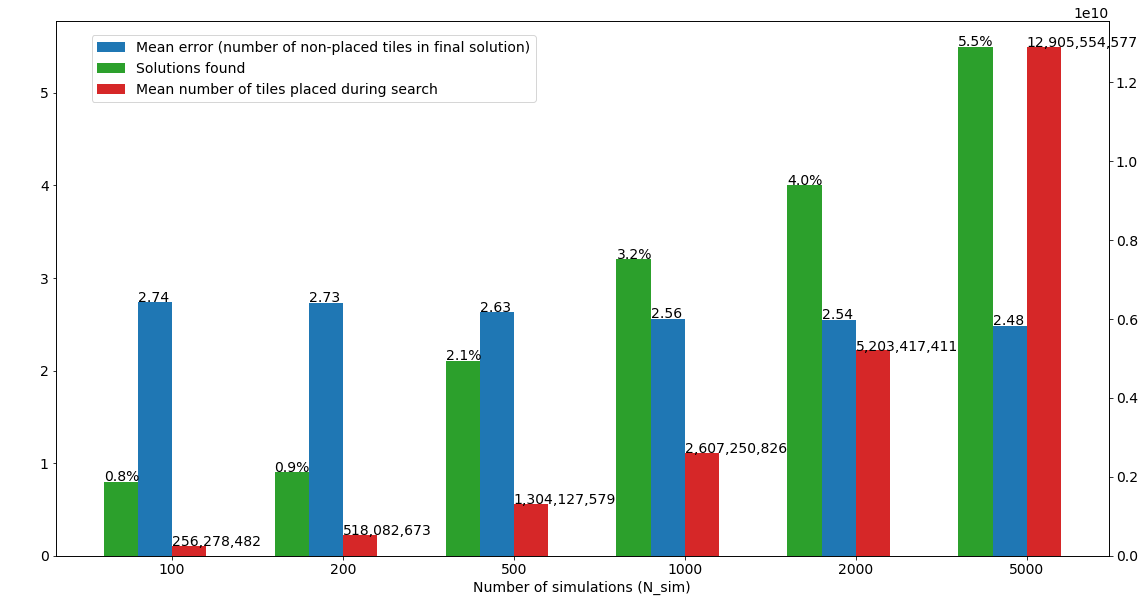

In [101]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator
N_SIM = [100, 200, 500, 1000, 2000, 5000]
SIMULATION_RUNS = N_SIM
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(0, len(SIMULATION_RUNS)):
        return SIMULATION_RUNS[int(tick_val)]
    else:
        return ''
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

for problem_type in ['g', 'b']:
    for n_simulations in SIMULATION_RUNS:
        common_args = {
            # 'problem_id__in': best_problem_ids,
            'strategy': 'avg_depth',
            # 'solution_tiles_order__isnull': True,
            'n_simulations': n_simulations,
            'improved_sel': True, 'score__isnull': False
        }
        print(common_args['strategy'])
        if problem_type == 'g':
            common_args['problem_id__in'] = best_problem_ids
        else:
            common_args['their_id__in'] = best_their_ids
        avg_score = np.average(np.array(Result.objects.filter(
            **common_args).order_by('their_id').values_list('score', flat=True)))
        results[n_simulations] = {'median score': avg_score}
        avg_tiles_array =  np.array(Result.objects.filter(
            # solution_found=True,
            **common_args).order_by('their_id').values_list('n_tiles_placed', flat=True))
        # avg_tiles = np.avg(avg_tiles_array)
        avg_tiles = np.sum(avg_tiles_array)
        # print(len(avg_tiles_array), sum(avg_tiles_array), avg_tiles, sum(avg_tiles_array) / len(avg_tiles_array), 'avg_tiles_array length')
        solutions_found = (Result.objects.filter(
            solution_found=True,**common_args).order_by('their_id').count() / 
            Result.objects.filter(**common_args).order_by('their_id').count() * 100)

        print(n_simulations, Result.objects.filter(**common_args).count())
        results[n_simulations]['median tiles placed'] = avg_tiles
        results[n_simulations]['solutions found'] = solutions_found

    fig,  ax1 = plt.subplots()
    x = np.arange(0, len(SIMULATION_RUNS) )
    print(x)
    y = np.arange(0,3)
    width_offset = 0.10
    width = 0.2 
    print(results, problem_type)
    for k in [100, 200, 500, 1000, 2000, 5000]:
        print(f"{results[k]['solutions found']}\t{results[k]['median tiles placed']}")
    for i, score_type in enumerate(['median score', 'median tiles placed', 'solutions found']):
        # print(result)
        sc = [v[score_type] for k, v in results.items()]
        current_ax = ax1
        color = 'tab:blue'
        label = 'Mean error (number of non-placed tiles in final solution)'
        if i == 1:
            color = 'tab:red'
            ax2 = ax1.twinx()
            current_ax = ax2
            width_offset = -width_offset
            label = 'Mean number of tiles placed during search'
        if i == 2:
            color = 'tab:green'
            # ax2 = ax1.twinx()
            width_offset = -3 *  width_offset
            label = 'Solutions found'
        current_ax.bar(x - width_offset, sc, width=width, 
                label=label, color=color)
        if i != 2:
            current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
            current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        for j, v in enumerate(sc): 
            offset = width_offset 
            text = '{:.2f}'.format(v)
            _offset = 0.1
            _offset_top = 0.01
            if v >  100:
                text = '{:,.0f}'.format(v)
                _offset = 0.10
                _offset_top = 50000.35
            if i == 2:
                text = '{:.1f}%'.format(v)
                if problem_type == 'g':
                    _offset_top = 0.1
            current_ax.text(x[j] - offset - _offset, v + _offset_top, text)

    plt.rcParams["font.size"] = 14
    # plt.yticks(ticks=np.arange(0, 4))
    ax1.set_xlabel('Number of simulations (N_sim)')
    # ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
    # ax2.set_ylabel('Median number of tiles placed during search')
    fig.legend(loc=(0.08, 0.83))
    fig.subplots_adjust(top=2.6, right=1.1)
    print('Number of tiles non-placed in correlation with simulation runs')
    plt.show()

In [86]:
Result.objects.filter(n_simulations=2000).values('score', 'problem_id')


from django.db.models import Count
their_ids_1 = Result.objects.filter(n_simulations=2000,
                                score__isnull=False,
                                their_id__in=best_their_ids, strategy='avg_depth').values_list('their_id', flat=True)

their_ids = Result.objects.filter(n_simulations=200,
                                score__isnull=False,
                                their_id__in=best_their_ids, strategy='avg_depth').values_list('their_id', flat=True)

print(set(their_ids_1) - set(their_ids))
print(their_ids, len(their_ids))

for n_sim in [100, 200, 500, 1000, 2000, 5000]:
    res = Result.objects.filter(n_simulations=n_sim,
                                score__isnull=False,
                                their_id__in=best_their_ids, strategy='avg_depth')
    print(len(res))
    their_ids = []
    for r in res:
        if r.their_id in their_ids:
            # r.delete()
            print(r.their_id, r.id)
        else:
            their_ids.append(r.their_id)

    # Result.objects.filter(their_id=23658, n_simulations=2000, strategy='max_depth').first()

set()
<QuerySet [22865, 23416, 23336, 23338, 23343, 23371, 23344, 23352, 23367, 23470, 23380, 23386, 23387, 23588, 23390, 23329, 23483, 23327, 23323, 23322, '...(remaining elements truncated)...']> 1000
1000
1000
1000
1000
1000
1000


In [96]:
print(Result.objects.filter(n_simulations=100, score__isnull=False, solution_found=True,
                      their_id__in=best_their_ids, strategy='max_depth').values('their_id','id', 'n_tiles_placed', 'tiles'))

Result.objects.filter(n_simulations=200, score__isnull=False,
                      their_id__in=[22720], strategy='max_depth').values('their_id','id', 'n_tiles_placed', 'tiles')


<QuerySet [{'their_id': 22720, 'id': 51875, 'n_tiles_placed': 202982, 'tiles': [[4, 1], [5, 1], [6, 1], [7, 1], [4, 2], [5, 2], [6, 2], [7, 2], [8, 2], [4, 3], [5, 3], [6, 3], [7, 3], [8, 3], [1, 4], [2, 4], [3, 4], [5, 4], [6, 4], [1, 5], [2, 5], [3, 5], [4, 5], [6, 5], [7, 5], [8, 5], [1, 6], [2, 6], [3, 6], [4, 6], [5, 6], [1, 7], [2, 7], [3, 7], [5, 7], [8, 7], [2, 8], [3, 8], [5, 8], [7, 8]]}]>


<QuerySet [{'their_id': 22720, 'id': 51874, 'n_tiles_placed': 560313, 'tiles': [[4, 1], [5, 1], [6, 1], [7, 1], [4, 2], [5, 2], [6, 2], [7, 2], [8, 2], [4, 3], [5, 3], [6, 3], [7, 3], [8, 3], [1, 4], [2, 4], [3, 4], [5, 4], [6, 4], [1, 5], [2, 5], [3, 5], [4, 5], [6, 5], [7, 5], [8, 5], [1, 6], [2, 6], [3, 6], [4, 6], [5, 6], [1, 7], [2, 7], [3, 7], [5, 7], [8, 7], [2, 8], [3, 8], [5, 8], [7, 8]]}]>

### Compare n_tiles

5 40 {'median score': 0.0}
6 40 {'median score': 0.0}
7 40 {'median score': 0.0}
8 40 {'median score': 0.0}
9 40 {'median score': 0.05}
10 40 {'median score': 0.025}
11 40 {'median score': 0.425}
12 40 {'median score': 0.45}
13 40 {'median score': 0.7}
14 40 {'median score': 0.875}
15 40 {'median score': 0.8}
16 40 {'median score': 1.675}
17 40 {'median score': 1.775}
18 40 {'median score': 1.375}
19 40 {'median score': 1.8}
20 40 {'median score': 0.25}
21 40 {'median score': 2.05}
22 40 {'median score': 1.925}
23 40 {'median score': 2.15}
24 40 {'median score': 2.15}
25 40 {'median score': 2.4}
26 40 {'median score': 3.5}
27 40 {'median score': 2.35}
28 40 {'median score': 2.475}
29 40 {'median score': 2.45}
30 40 {'median score': 2.725}
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30]
Number of tiles non-placed in correlation with simulation runs


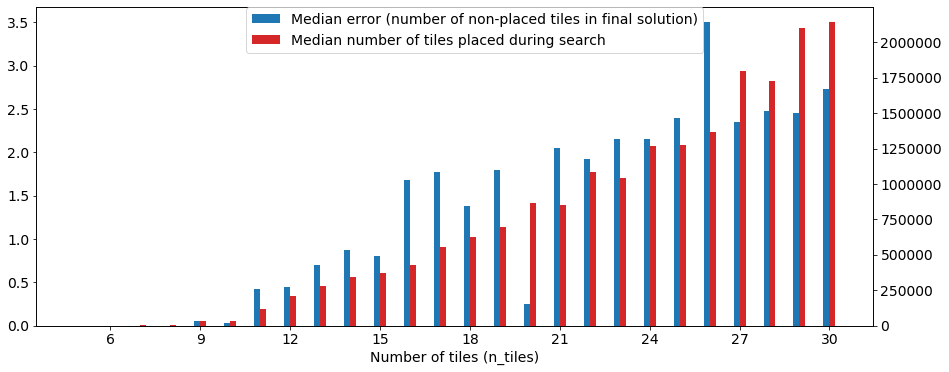

In [102]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator

N_TILES = list(range(5, 31))

def format_fn(tick_val, tick_pos):
    return str(int(tick_val))
    if int(tick_val) in N_TILES:
        return N_TILES[int(tick_val)]
    else:
        return ''
    
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

LAST_N_RECORDS = 40

for n_tiles in N_TILES:
    common_args = {
        'strategy': 'max_depth', 'n_tiles': n_tiles,
        'score__isnull': False, 'n_tiles_placed__isnull': False,
        'n_simulations': 1000, 'problem_generator': 'guillotine'
    }
    res_avg_score = Result.objects.filter(**common_args).order_by('-created_on').values_list('score', flat=True)[:LAST_N_RECORDS]
    if res_avg_score:
        avg_score = np.average(np.array(res_avg_score))
    else:
        avg_score = 0
    results[n_tiles] = {'median score': avg_score}
    
    res_tiles_placed = Result.objects.filter(**common_args).order_by('-created_on').values_list('n_tiles_placed', flat=True)[:LAST_N_RECORDS]
    if res_tiles_placed:
        avg_tiles = np.average(np.array(res_tiles_placed))
    else:
        avg_tiles = 0
    print(n_tiles, res_tiles_placed.count(), results[n_tiles])
    results[n_tiles]['median tiles placed'] = avg_tiles
    
fig,  ax1 = plt.subplots()
x = np.arange(N_TILES[0], N_TILES[-1] + 1)
print(x)
y = np.arange(0,3)
width_offset = 0.10
width = 0.2 
for i, score_type in enumerate(['median score', 'median tiles placed']):
    # print(result)
    sc = [v[score_type] for k, v in results.items()]
    current_ax = ax1
    color = 'tab:blue'
    label = 'Median error (number of non-placed tiles in final solution)'
    if i == 1:
        color = 'tab:red'
        ax2 = ax1.twinx()
        current_ax = ax2
        width_offset = -width_offset
        label = 'Median number of tiles placed during search'
    current_ax.bar(x - width_offset, sc, width=width, 
            label=label, color=color)
    current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # for i, v in enumerate(sc): 
    #     offset = width_offset 
    #     text = '{:.3f}'.format(v)
    #     _offset = 0.12
    #     _offset_top = 0.01
    #     if v >  10:
    #         text = '{:.0f}'.format(v)
    #         _offset = 0.10
    #         _offset_top = 50000.35
    #     current_ax.text(x[i] - offset - _offset, v + _offset_top, text)
   
plt.rcParams["font.size"] = 14
# plt.yticks(ticks=np.arange(0, 4))
ax1.set_xlabel('Number of tiles (n_tiles)')
# ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
# ax2.set_ylabel('Median number of tiles placed during search')
fig.legend(loc='upper center')
fig.subplots_adjust(top=1.6)
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

### Tiles placed (Huristic vs MCTS)

In [ ]:
instances_where_solution_is_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian').values('n_tiles_placed', 'their_tiles_placed')
scores_df = pd.DataFrame.from_records(instances_where_solution_is_found)
scores_df

In [ ]:
STRATEGIES = ['avg_depth', 'max_depth']
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'their_id__in': best_their_ids
}
N_SIM = [100, 200, 500, 1000, 2000, 5000]
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        solutions_found = Result.objects.filter(
            solution_found=True, problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
             problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        error = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('score', flat=True)))
        print(f'Florian instances with {n_sim} simulations and strategy {strategy}:')
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print(f'{solutions_found / solutions_not_found * 100 : .1f}% \t {int(round(tiles_placed)):,} \t {error}')
        print()

In [ ]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}

for strategy in STRATEGIES:
    for n_sim in N_SIM:
        print(f'Guillotine instances - {n_sim} - {strategy}:')
        solutions_found = Result.objects.filter(
            solution_found=True,  problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
            problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        error = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('score', flat=True)))
        
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print(f'error: {error}')
        print(f'{solutions_found / solutions_not_found * 100 : .1f}% \t {int(round(tiles_placed)):,} \t {error}')
        print()

In [ ]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian').aggregate(Avg('their_tiles_placed'))
        print('NG instances'); print('-' * 20)

        print('Florian tiles placed:', average_tiles_placed_deterministic)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic); print()

        print('G instances'); print('-' * 20)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='guillotine', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic)

In [13]:
import csv
ids_in_file = set()
lines_to_write = []
b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')
solved_ids = set(b_problems.values_list('id', flat=True))
with open('b_solved_by_exhaustive_solver.csv', 'w') as outputfile:
    with open('output_braam/combined.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(spamreader):
            print(row[0])
            if i == 0:
                lines_to_write.append(row)
                continue
            if row[0] in ids_in_file:
                print('skipped id:', row[0])
                continue
            if row[0] == 'job_id' or int(row[0]) not in solved_ids:
                continue
            ids_in_file.add(row[0])
            lines_to_write.append(row)
            row[6] = f'"{row[6]}"'
            
    for line in lines_to_write:
        outputfile.write(','.join(line) + '\n')

job_id
46542
46501
42982
42976
42964
42952
27971
27967
27963
27959
27955
27951
27947
27915
27907
27895
27684
27680
27676
27672
27660
27637
27633
27629
27613
27609
27605
27601
27577
27569
27565
27529
27525
27521
27518
27514
27510
27506
27502
27498
27494
27490
27486
27482
27478
27474
27470
27466
27395
27391
27387
27379
27375
27371
27304
27300
27296
27292
27112
27096
27092
27088
27080
27076
27072
26692
26620
26608
26584
26572
26452
26392
26344
26332
25985
25974
25962
25950
25938
25926
25901
25889
25877
25865
25668
25656
25644
25423
25363
25351
25339
25183
25147
25088
25076
25064
25028
24963
24903
24891
24867
24724
24493
24481
24397
24385
24265
24253
24229
24205
24157
24110
24074
24062
24049
24037
24025
24013
23811
23799
23776
23764
23752
23740
23369
23353
23309
23093
23081
23069
23035
22927
22915
22880
22844
22808
22784
22772
22676
22664
22640
22628
22616
22580
22413
22356
22344
22332
job_id
46535
46517
46510
28271
28267
28195
28191
28187
28183
28179
28175
28171
28167
28163
28103
28099
28

In [161]:
'''
How hard are the problems '''
for i, x in enumerate(Result.objects.filter(
    their_id__in=best_their_ids, solution_found=True, n_simulations=5000
).order_by('-n_tiles_placed').values('their_id', 'n_tiles_placed').distinct()
    ):
    print(i, x)

0 {'their_id': 22822, 'n_tiles_placed': 16943394}
1 {'their_id': 22710, 'n_tiles_placed': 16378348}
2 {'their_id': 22743, 'n_tiles_placed': 16154762}
3 {'their_id': 22693, 'n_tiles_placed': 15990703}
4 {'their_id': 22895, 'n_tiles_placed': 15152766}
5 {'their_id': 22805, 'n_tiles_placed': 14636855}
6 {'their_id': 22887, 'n_tiles_placed': 13314590}
7 {'their_id': 23033, 'n_tiles_placed': 13281214}
8 {'their_id': 22840, 'n_tiles_placed': 12708994}
9 {'their_id': 22918, 'n_tiles_placed': 12513527}
10 {'their_id': 22869, 'n_tiles_placed': 12206707}
11 {'their_id': 22682, 'n_tiles_placed': 12181915}
12 {'their_id': 22681, 'n_tiles_placed': 12035419}
13 {'their_id': 22838, 'n_tiles_placed': 12009445}
14 {'their_id': 22810, 'n_tiles_placed': 11951352}
15 {'their_id': 22729, 'n_tiles_placed': 11918354}
16 {'their_id': 22785, 'n_tiles_placed': 11897190}
17 {'their_id': 22801, 'n_tiles_placed': 11754220}
18 {'their_id': 23123, 'n_tiles_placed': 11697627}
19 {'their_id': 22856, 'n_tiles_placed': 

In [166]:
'''
How hard are the problems '''
for i, x in enumerate(Result.objects.filter(
    problem_id__in=best_problem_ids, solution_found=True, n_simulations=5000, strategy='avg_depth'
).order_by('-n_tiles_placed').values('problem_id').distinct()
    ):
    print(i, x)

0 {'problem_id': '5f7a784a-7571-4a08-80b2-883c1cfc65de'}
1 {'problem_id': 'e76ae306-e973-4394-b4a6-1f960954d6b2'}
2 {'problem_id': '4960f82c-c8ab-41e8-adf4-5c2e027659db'}
3 {'problem_id': 'e33be682-c812-436c-a0e3-e8e84ad8f0b3'}
4 {'problem_id': 'c82dbb10-2c25-4df8-8bc8-3f04089d6ba0'}
5 {'problem_id': '26dbe7d9-a120-4bfc-b310-996a311dd670'}
6 {'problem_id': '46510762-5777-441d-8bb2-ceef2cb71716'}
7 {'problem_id': 'ef71bda5-2c37-4f1e-8f57-cc4680210ac0'}
8 {'problem_id': '106be4a1-9187-4543-b452-70608da08736'}
9 {'problem_id': '0233ff0f-cc85-4364-be8a-ead4fdb66453'}
10 {'problem_id': '89704343-03c7-44c4-abb4-32a932bded55'}
11 {'problem_id': '9d1dd255-27c3-4f5d-ac6c-cac2f2c05eed'}
12 {'problem_id': '25d5d999-f2e2-42a8-b32f-73dd986ce507'}
13 {'problem_id': '2c381249-93b9-4b32-9480-50ccb26c0223'}
14 {'problem_id': '59c3e90b-597e-4c82-bb96-81969e5d97db'}
15 {'problem_id': 'e365443a-c62e-4701-afe4-75ace9562fc2'}
16 {'problem_id': '201bb0cd-bc2c-44f0-adca-9e1af14e7599'}
17 {'problem_id': '5a313

In [9]:
problem_ids = {k: i for i, k in enumerate(
    list(set(Result.objects.filter(problem_id__isnull=False, problem_id__in=best_problem_ids).values_list('problem_id', flat=True).distinct()))
)}
problem_ids

{'b1f620af-61f5-4951-9270-83cb54c7c738': 0,
 '9bd68225-08f8-4d64-bed9-c81bb29043e9': 1,
 '15e41217-7bff-49b9-bb4a-cf01ffab4ba3': 2,
 'e50471f5-e496-44d5-a658-af86f4d4a134': 3,
 'f6a960e3-c537-4944-9779-4a117d6268be': 4,
 '85d31a39-928a-4af2-bbe1-cca1c3f91cdf': 5,
 'fa9ee30f-9729-48e1-8009-2e7ae53e1626': 6,
 'd07cf9f8-7f7e-4db6-9793-94e30146e5ba': 7,
 '481c6c3e-6bb3-41b3-9c0c-6f26d842d409': 8,
 '722b84fc-f41c-461d-8578-a93c88992139': 9,
 '92580737-5014-479d-bd60-db795d108cdb': 10,
 '945c812b-0d65-4dd3-b488-f86b01697ee2': 11,
 '1a58e472-df0f-4df4-ad1e-d4ce71b58eef': 12,
 '828fe4b6-046e-4622-a193-dbb62f5cea1a': 13,
 '9d7acb2b-f2bb-4ea1-95b2-5eda32cc7790': 14,
 '6389bfce-8361-42b2-ac8e-d56b0ceedac7': 15,
 '5f29514f-fc6d-43bf-a993-cd591205130e': 16,
 '8c1a440a-482b-4b2c-b23a-566709b4a5ec': 17,
 'f5312650-1bb7-4d50-9082-a083947c03e9': 18,
 '31101d92-b92f-46e3-8759-d2eca8a2ea4a': 19,
 'e3435183-83ff-40b6-85af-26f7bc87a0a4': 20,
 '6e3f5ddf-fd01-4bac-974b-333b1e435efb': 21,
 '388804bf-80ed-408f

In [10]:
for r in Result.objects.filter(problem_id__in=best_problem_ids):
    r.int_problem_id = problem_ids[r.problem_id]
    r.save()

In [1]:
Result.objects.filter(problem_id__isnull=False).count()
import pickle
with open(r"best_problem_ids.pickle", 'rb') as f:
    best_problem_ids = pickle.load(f) 
with open(r"best_their_ids.pickle", 'rb') as f:
    best_their_ids = pickle.load(f) 

In [5]:
their_ids = {k: i for i, k in enumerate(
    list(set(Result.objects.filter(their_id__in=best_their_ids).values_list('their_id', flat=True).distinct()))
)}

In [6]:

k = 0
from binpack.models import Result
for r in Result.objects.filter(their_id__in=best_their_ids, int_problem_id__isnull=True):

    r.int_problem_id = their_ids[r.their_id]
    r.save()

In [11]:
their_ids

with open('id_to_their_id.csv', 'w') as f:
    for k, v in their_ids.items():
        f.write(f'{k},{v}\n')
    

In [12]:
problem_ids

with open('id_to_problem_id.csv', 'w') as f:
    for k, v in problem_ids.items():
        f.write(f'{k},{v}\n')
    